# Hashiwokakero Solver Benchmark Analysis

## Muc tieu so sanh
Danh gia va so sanh hieu nang cua 4 thuat toan giai Hashiwokakero:
1. **PySATSolver** - SAT-based approach
2. **AStarSolver** - A* heuristic search
3. **BacktrackingSolver** - Constraint satisfaction backtracking
4. **BruteForceSolver** - Exhaustive enumeration

## Tieu chi danh gia
- **Thoi gian thuc thi** (Time)
- **Bo nho su dung** (Memory)
- **Ty le thanh cong** (Success Rate)
- **Do chinh xac** (Correctness)
- **Kha nang mo rong** (Scalability)

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Enhanced styling
sns.set_theme(style="white", palette="tab10")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 10
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["axes.labelsize"] = 8

# Custom color palette
colors = {
    'PySATSolver': '#2ecc71',        # Green
    'AStarSolver': '#3498db',         # Blue
    'BacktrackingSolver': '#f39c12',  # Orange
    'BruteForceSolver': '#e74c3c'     # Red
}

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Setup & Data Loading

In [26]:
benchmark_path = Path("src/benchmark_report.csv")
df = pd.read_csv(benchmark_path)

# Clean and prepare data
df["Time (s)"] = pd.to_numeric(df["Time (s)"], errors="coerce")
df["Memory (MB)"] = pd.to_numeric(df["Memory (MB)"], errors="coerce")
df["Correct"] = df["Correct"].astype(bool)

# Add timeout flag for easier filtering
df["Timeout"] = df["Status"] == "TIMEOUT"

print(f"Loaded {len(df)} benchmark records")
print(f"Inputs: {df['Input'].nunique()}, Solvers: {df['Solver'].nunique()}")
print(f"\nPreview:")
df.head()

Loaded 44 benchmark records
Inputs: 11, Solvers: 4

Preview:


,Input,Solver,Status,Time (s),Memory (MB),Correct,Pass 1min,Pass 2min,Pass 5min,Timeout
0,input-00.txt,PySATSolver,OK,0.0011,0.0415,True,True,True,True,False
1,input-00.txt,AStarSolver,OK,0.0519,0.1753,True,True,True,True,False
2,input-00.txt,BacktrackingSolver,OK,0.0533,0.0109,True,True,True,True,False
3,input-00.txt,BruteForceSolver,OK,7.2939,0.0110,True,True,True,True,False
4,input-01.txt,PySATSolver,OK,0.0018,0.0483,True,True,True,True,False


In [27]:
# Success rate and timeout analysis
success_stats = df.groupby("Solver").agg({
    "Correct": ["sum", "mean"],
    "Timeout": ["sum", "mean"],
    "Time (s)": ["mean", "median", "max"],
    "Memory (MB)": ["mean", "median", "max"]
}).round(4)

success_stats.columns = ['_'.join(col).strip() for col in success_stats.columns.values]
success_stats = success_stats.rename(columns={
    "Correct_sum": "Correct_Count",
    "Correct_mean": "Success_Rate",
    "Timeout_sum": "Timeout_Count",
    "Timeout_mean": "Timeout_Rate"
})

print("Performance Summary by Solver:\n")
success_stats

Performance Summary by Solver:



,Correct_Count,Success_Rate,Timeout_Count,Timeout_Rate,Time (s)_mean,Time (s)_median,Time (s)_max,Memory (MB)_mean,Memory (MB)_median,Memory (MB)_max
Solver,,,,,,,,,,
AStarSolver,4,0.3636,5,0.4545,138.5167,22.5449,300.0000,894.6513,95.9118,2587.6647
BacktrackingSolver,4,0.3636,7,0.6364,194.3936,299.9914,300.0000,0.0557,0.0307,0.1843
BruteForceSolver,1,0.0909,10,0.9091,273.3900,300.0000,300.0000,0.0312,0.0177,0.0957
PySATSolver,11,1.0000,0,0.0000,0.0774,0.0241,0.5346,0.3250,0.1643,1.1667


## 2. Overall Statistics

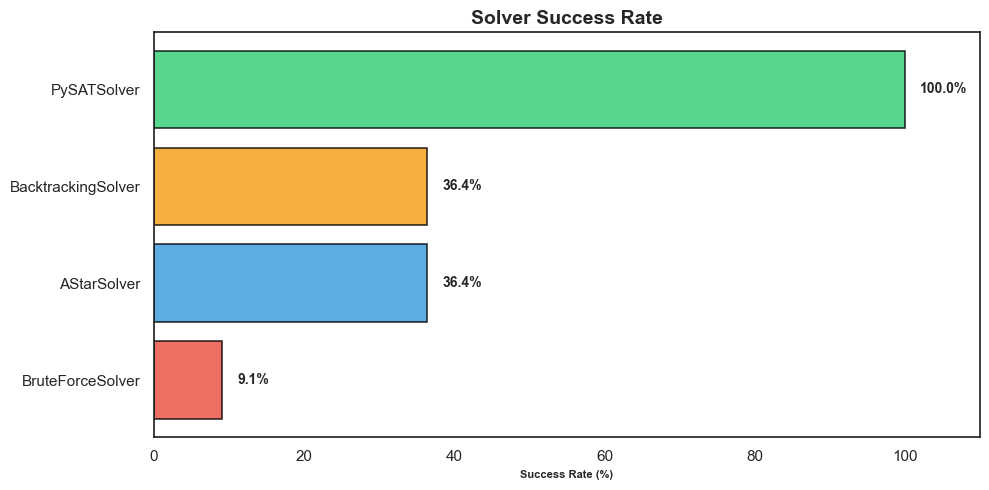

In [28]:
# Success rate bar chart
solver_stats = df.groupby("Solver").agg({
    "Correct": "mean",
    "Timeout": "mean"
}).reset_index()
solver_stats["Success_Rate"] = solver_stats["Correct"] * 100
solver_stats["Timeout_Rate"] = solver_stats["Timeout"] * 100

# Sort by success rate
solver_stats = solver_stats.sort_values("Success_Rate", ascending=True)

plt.figure(figsize=(10, 5))
bars = plt.barh(solver_stats["Solver"], solver_stats["Success_Rate"], 
                color=[colors[s] for s in solver_stats["Solver"]], alpha=0.8, edgecolor='black', linewidth=1.2)
plt.xlabel("Success Rate (%)", fontweight='bold')
plt.title("Solver Success Rate", fontsize=14, fontweight='bold')
plt.xlim(0, 110)

# Add percentage labels
for i, (bar, val) in enumerate(zip(bars, solver_stats["Success_Rate"])):
    plt.text(val + 2, i, f'{val:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

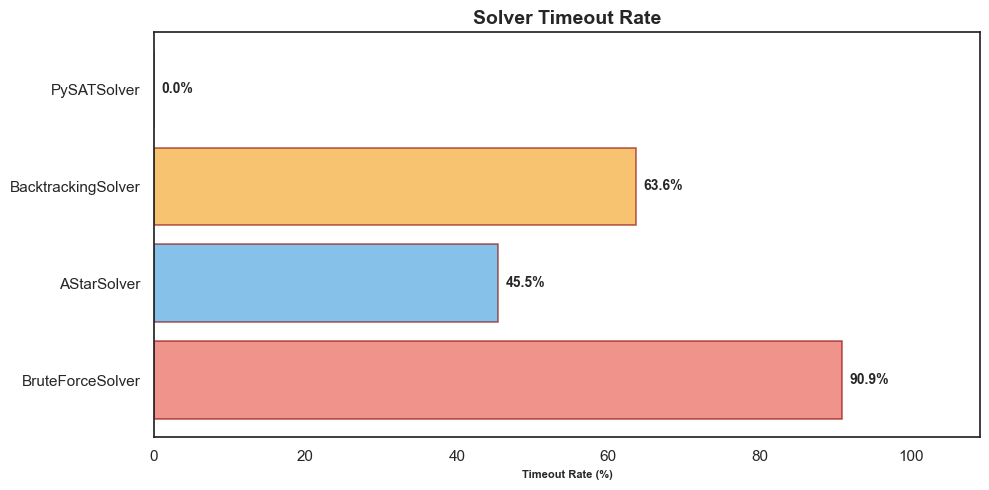

In [29]:
# Timeout rate bar chart
plt.figure(figsize=(10, 5))
bars2 = plt.barh(solver_stats["Solver"], solver_stats["Timeout_Rate"],
                 color=[colors[s] for s in solver_stats["Solver"]], alpha=0.6, edgecolor='darkred', linewidth=1.2)
plt.xlabel("Timeout Rate (%)", fontweight='bold')
plt.title("Solver Timeout Rate", fontsize=14, fontweight='bold')
plt.xlim(0, max(solver_stats["Timeout_Rate"]) * 1.2)

for i, (bar, val) in enumerate(zip(bars2, solver_stats["Timeout_Rate"])):
    plt.text(val + 1, i, f'{val:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Success Rate Comparison

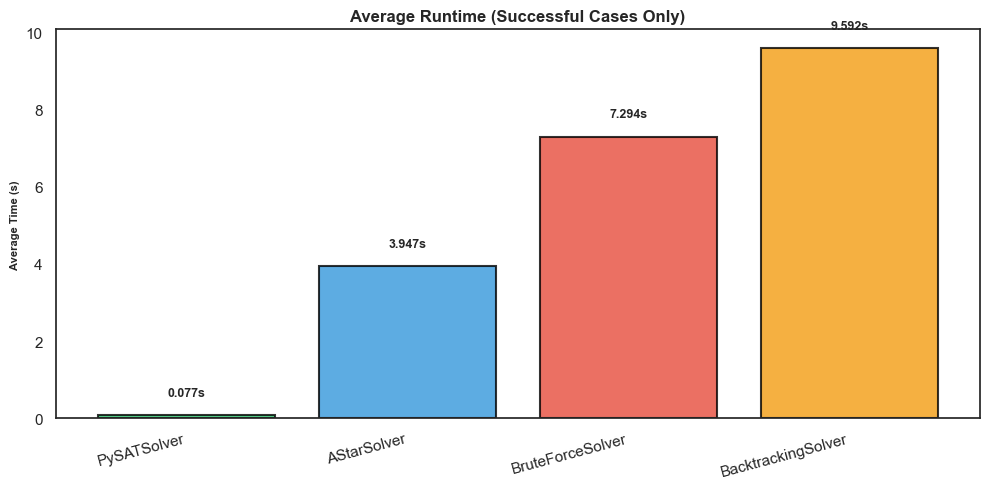

In [30]:
# Filter out timeouts for fair time comparison
df_success = df[~df["Timeout"]].copy()

# Average runtime comparison (bar chart)
avg_time = df_success.groupby("Solver")["Time (s)"].mean().sort_values()

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(avg_time)), avg_time.values, 
               color=[colors[s] for s in avg_time.index], alpha=0.8, edgecolor='black', linewidth=1.5)
plt.xticks(range(len(avg_time)), avg_time.index, rotation=15, ha='right')
plt.ylabel("Average Time (s)", fontweight='bold')
plt.title("Average Runtime (Successful Cases Only)", fontsize=12, fontweight='bold')

for i, (bar, val) in enumerate(zip(bars, avg_time.values)):
    plt.text(i, val + 0.5, f'{val:.3f}s', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

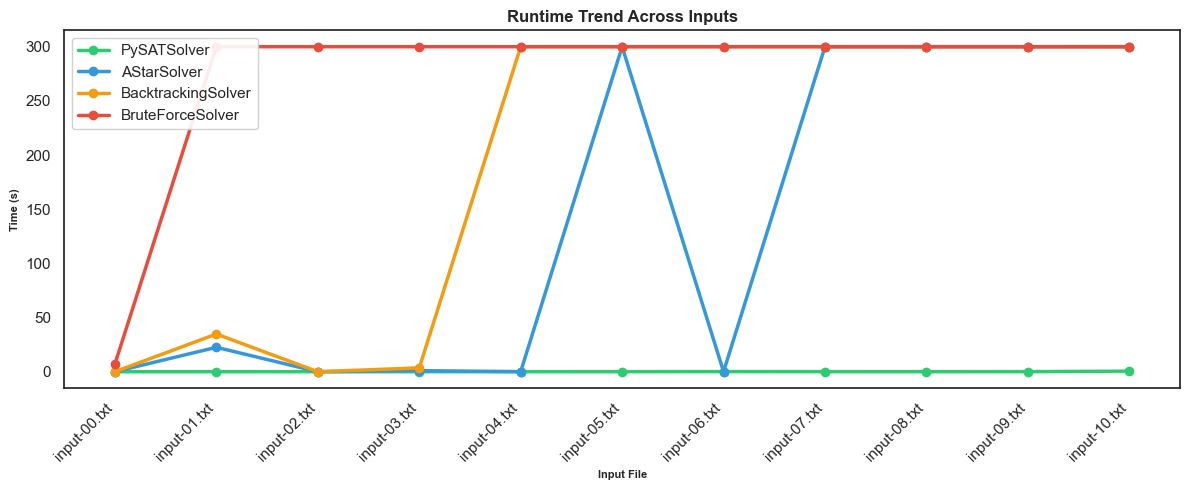

In [31]:
# Runtime across inputs (line plot)
plt.figure(figsize=(12, 5))
for solver in df["Solver"].unique():
    solver_data = df[df["Solver"] == solver].sort_values("Input")
    plt.plot(solver_data["Input"], solver_data["Time (s)"], 
            marker='o', label=solver, linewidth=2.5, markersize=6, color=colors[solver])

plt.xlabel("Input File", fontweight='bold')
plt.ylabel("Time (s)", fontweight='bold')
plt.title("Runtime Trend Across Inputs", fontsize=12, fontweight='bold')
plt.legend(loc='upper left', framealpha=0.9)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\GIGA\AppData\Local\Temp\ipykernel_15816\747294725.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot([df_success[df_success["Solver"] == s]["Time (s)"].values for s in solver_order],


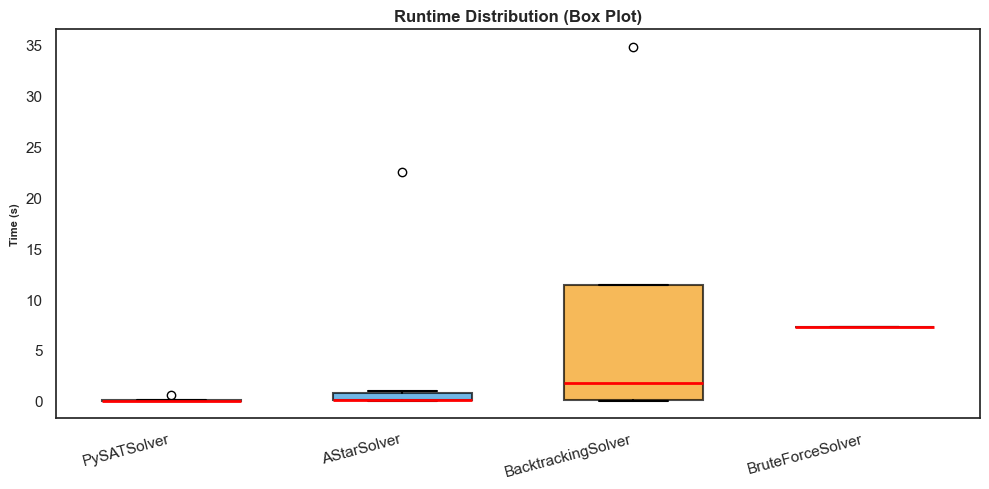

In [32]:
# Runtime boxplot
solver_order = df_success.groupby("Solver")["Time (s)"].median().sort_values().index

plt.figure(figsize=(10, 5))
box = plt.boxplot([df_success[df_success["Solver"] == s]["Time (s)"].values for s in solver_order],
                   labels=solver_order, patch_artist=True, widths=0.6,
                   boxprops=dict(linewidth=1.5), whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5), medianprops=dict(linewidth=2, color='red'))

for patch, solver in zip(box['boxes'], solver_order):
    patch.set_facecolor(colors[solver])
    patch.set_alpha(0.7)

plt.ylabel("Time (s)", fontweight='bold')
plt.title("Runtime Distribution (Box Plot)", fontsize=12, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

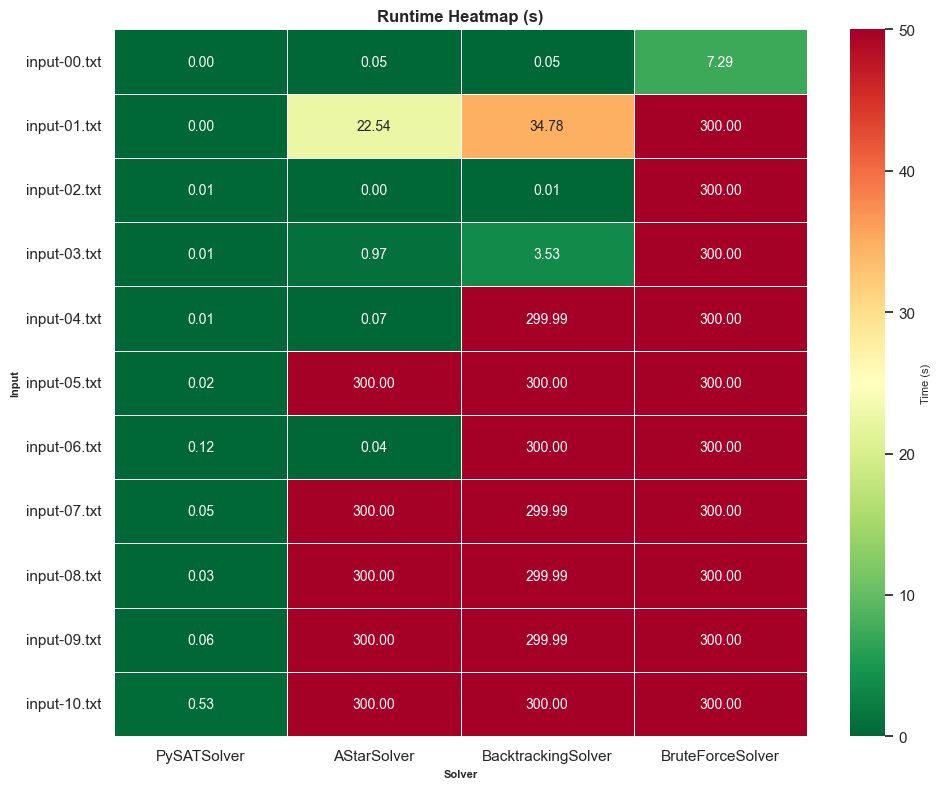

In [33]:
# Heatmap of runtime
pivot_time = df.pivot(index="Input", columns="Solver", values="Time (s)")
pivot_time = pivot_time[['PySATSolver', 'AStarSolver', 'BacktrackingSolver', 'BruteForceSolver']]

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_time, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            linewidths=0.5, cbar_kws={'label': 'Time (s)'},
            vmin=0, vmax=50, cbar=True)
plt.title("Runtime Heatmap (s)", fontsize=12, fontweight='bold')
plt.xlabel("Solver", fontweight='bold')
plt.ylabel("Input", fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Runtime Performance Analysis

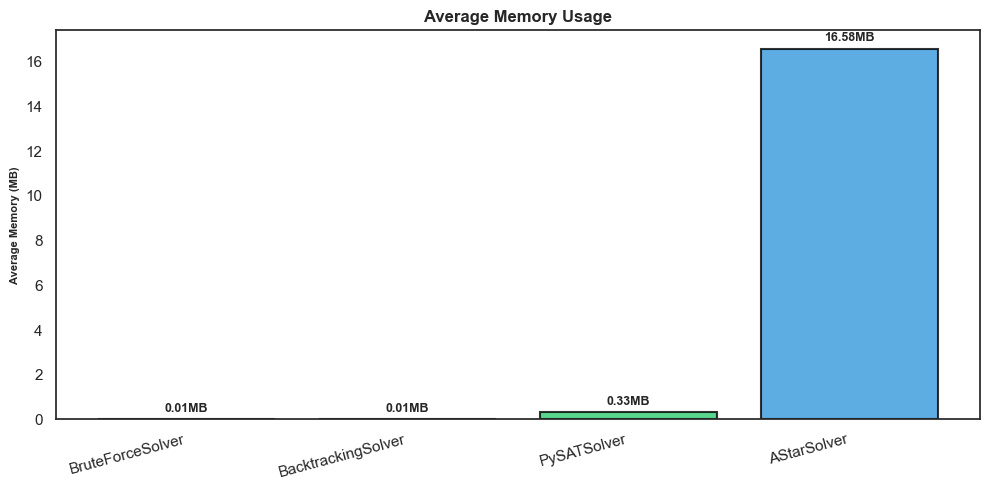

In [34]:
# Average memory usage
avg_mem = df_success.groupby("Solver")["Memory (MB)"].mean().sort_values()

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(avg_mem)), avg_mem.values,
               color=[colors[s] for s in avg_mem.index], alpha=0.8, edgecolor='black', linewidth=1.5)
plt.xticks(range(len(avg_mem)), avg_mem.index, rotation=15, ha='right')
plt.ylabel("Average Memory (MB)", fontweight='bold')
plt.title("Average Memory Usage", fontsize=12, fontweight='bold')

for i, (bar, val) in enumerate(zip(bars, avg_mem.values)):
    plt.text(i, val + max(avg_mem) * 0.02, f'{val:.2f}MB', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

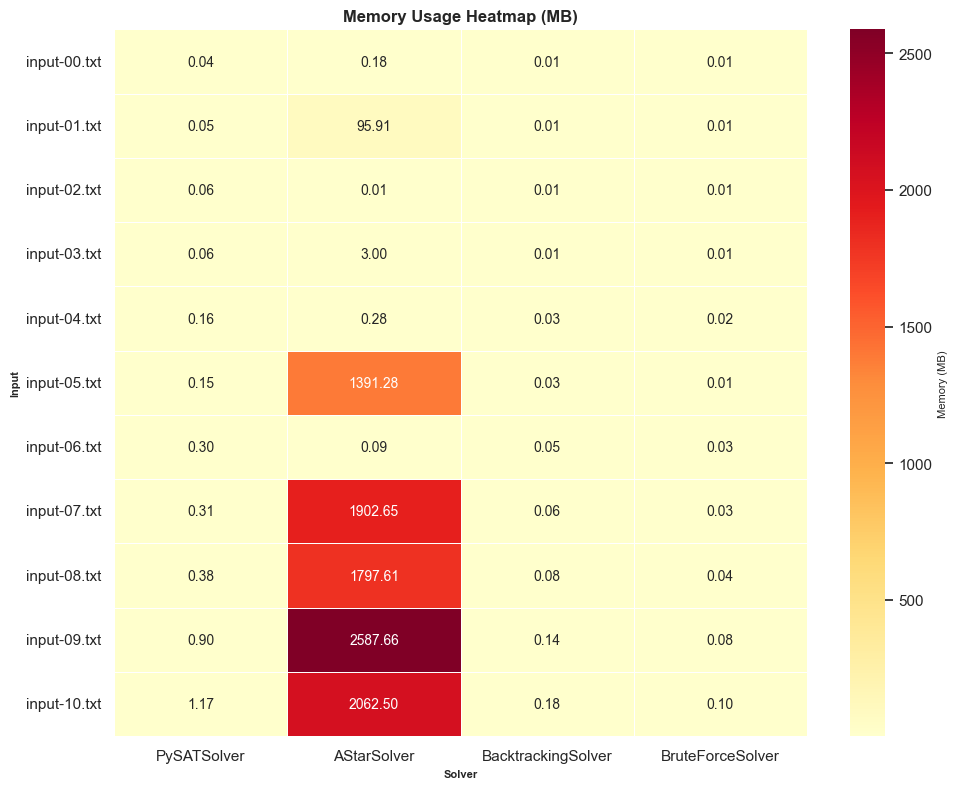

In [35]:
# Memory heatmap
pivot_mem = df.pivot(index="Input", columns="Solver", values="Memory (MB)")
pivot_mem = pivot_mem[['PySATSolver', 'AStarSolver', 'BacktrackingSolver', 'BruteForceSolver']]

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_mem, annot=True, fmt='.2f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Memory (MB)'},
            cbar=True)
plt.title("Memory Usage Heatmap (MB)", fontsize=12, fontweight='bold')
plt.xlabel("Solver", fontweight='bold')
plt.ylabel("Input", fontweight='bold')
plt.tight_layout()
plt.show()

In [43]:
# Summary comparison table
summary_comparison = comparison_df.groupby('Solver').agg({
    'Correct': ['sum', 'mean'],
    'Time (s)': ['mean', 'median', 'min', 'max'],
    'Memory (MB)': ['mean', 'median', 'min', 'max']
}).round(4)

summary_comparison.columns = ['_'.join(col).strip() for col in summary_comparison.columns.values]

print("="*80)
print("HEAD-TO-HEAD SUMMARY: A* vs Backtracking vs BruteForce")
print("="*80)
print(summary_comparison)
print("="*80)

# Win-loss record
print("\nWIN-LOSS RECORD (by input):")
for input_file in pivot_success.index:
    results = pivot_success.loc[input_file]
    print(f"\n{input_file}:")
    for solver in comparison_solvers:
        status = "✓ Success" if results[solver] == 1 else "✗ Failed"
        time = pivot_time.loc[input_file, solver]
        mem = pivot_memory.loc[input_file, solver]
        print(f"  {solver:20s}: {status:12s} | Time: {time:7.2f}s | Memory: {mem:8.2f}MB")

HEAD-TO-HEAD SUMMARY: A* vs Backtracking vs BruteForce
                    Correct_sum  Correct_mean  Time (s)_mean  Time (s)_median  \
Solver                                                                          
AStarSolver                   4        0.3636       138.5167          22.5449   
BacktrackingSolver            4        0.3636       194.3936         299.9914   
BruteForceSolver              1        0.0909       273.3900         300.0000   

                    Time (s)_min  Time (s)_max  Memory (MB)_mean  \
Solver                                                             
AStarSolver               0.0026         300.0          894.6513   
BacktrackingSolver        0.0073         300.0            0.0557   
BruteForceSolver          7.2939         300.0            0.0312   

                    Memory (MB)_median  Memory (MB)_min  Memory (MB)_max  
Solver                                                                    
AStarSolver                    95.9118          

In [42]:
# Performance ratios: How many times faster/slower
ratio_analysis = pd.DataFrame()

for input_file in pivot_time.index:
    bt_time = pivot_time.loc[input_file, 'BacktrackingSolver']
    astar_time = pivot_time.loc[input_file, 'AStarSolver']
    bf_time = pivot_time.loc[input_file, 'BruteForceSolver']
    
    # Skip if timeout (300s)
    if bt_time < 300 and astar_time < 300:
        ratio_analysis.loc[input_file, 'Backtracking/A* Time Ratio'] = bt_time / astar_time
    else:
        ratio_analysis.loc[input_file, 'Backtracking/A* Time Ratio'] = np.nan
        
    if bf_time < 300 and astar_time < 300:
        ratio_analysis.loc[input_file, 'BruteForce/A* Time Ratio'] = bf_time / astar_time
    else:
        ratio_analysis.loc[input_file, 'BruteForce/A* Time Ratio'] = np.nan
        
    if bt_time < 300 and bf_time < 300:
        ratio_analysis.loc[input_file, 'Backtracking/BruteForce Time Ratio'] = bt_time / bf_time
    else:
        ratio_analysis.loc[input_file, 'Backtracking/BruteForce Time Ratio'] = np.nan

print("Performance Ratios (< 1 means first is faster):")
print(ratio_analysis.round(2))
print("\nAverage Ratios:")
print(ratio_analysis.mean().round(2))

Performance Ratios (< 1 means first is faster):
              Backtracking/A* Time Ratio  BruteForce/A* Time Ratio  \
input-00.txt                        1.03                    140.54   
input-01.txt                        1.54                       NaN   
input-02.txt                        2.81                       NaN   
input-03.txt                        3.62                       NaN   
input-04.txt                     4392.25                       NaN   
input-05.txt                         NaN                       NaN   
input-06.txt                     7176.97                       NaN   
input-07.txt                         NaN                       NaN   
input-08.txt                         NaN                       NaN   
input-09.txt                         NaN                       NaN   
input-10.txt                         NaN                       NaN   

              Backtracking/BruteForce Time Ratio  
input-00.txt                                0.01  
input-01.

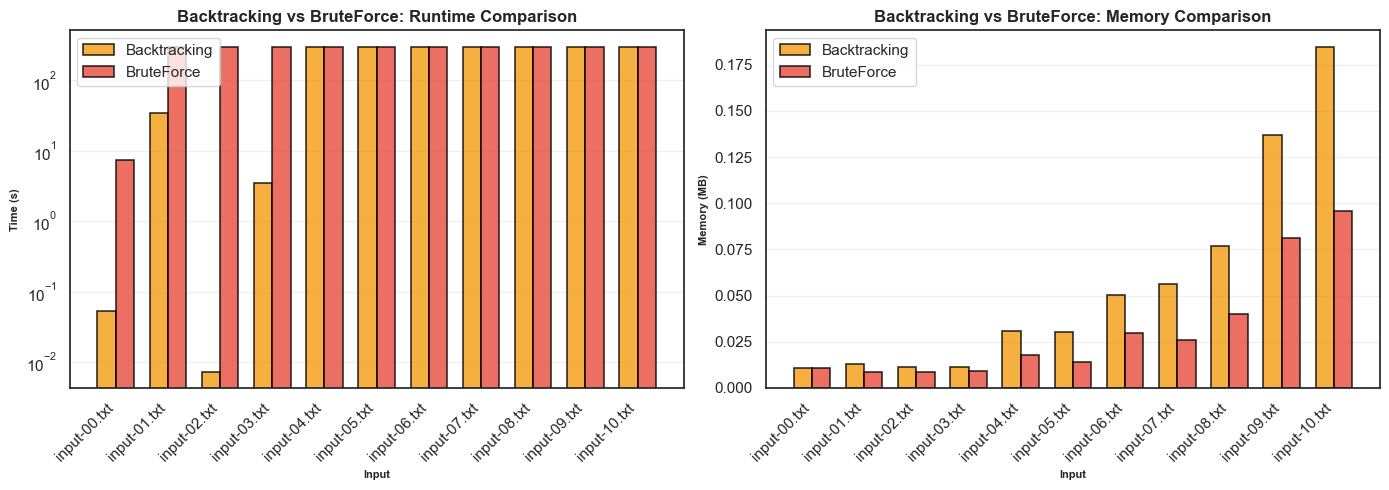

In [41]:
# Pair-wise comparison: Backtracking vs BruteForce
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time comparison
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, pivot_time['BacktrackingSolver'], width,
                label='Backtracking', color=colors['BacktrackingSolver'],
                alpha=0.8, edgecolor='black', linewidth=1.2)
bars2 = ax1.bar(x + width/2, pivot_time['BruteForceSolver'], width,
                label='BruteForce', color=colors['BruteForceSolver'],
                alpha=0.8, edgecolor='black', linewidth=1.2)

ax1.set_xlabel('Input', fontweight='bold')
ax1.set_ylabel('Time (s)', fontweight='bold')
ax1.set_title('Backtracking vs BruteForce: Runtime Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(inputs, rotation=45, ha='right')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.3)

# Memory comparison
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, pivot_memory['BacktrackingSolver'], width,
                label='Backtracking', color=colors['BacktrackingSolver'],
                alpha=0.8, edgecolor='black', linewidth=1.2)
bars4 = ax2.bar(x + width/2, pivot_memory['BruteForceSolver'], width,
                label='BruteForce', color=colors['BruteForceSolver'],
                alpha=0.8, edgecolor='black', linewidth=1.2)

ax2.set_xlabel('Input', fontweight='bold')
ax2.set_ylabel('Memory (MB)', fontweight='bold')
ax2.set_title('Backtracking vs BruteForce: Memory Comparison', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(inputs, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

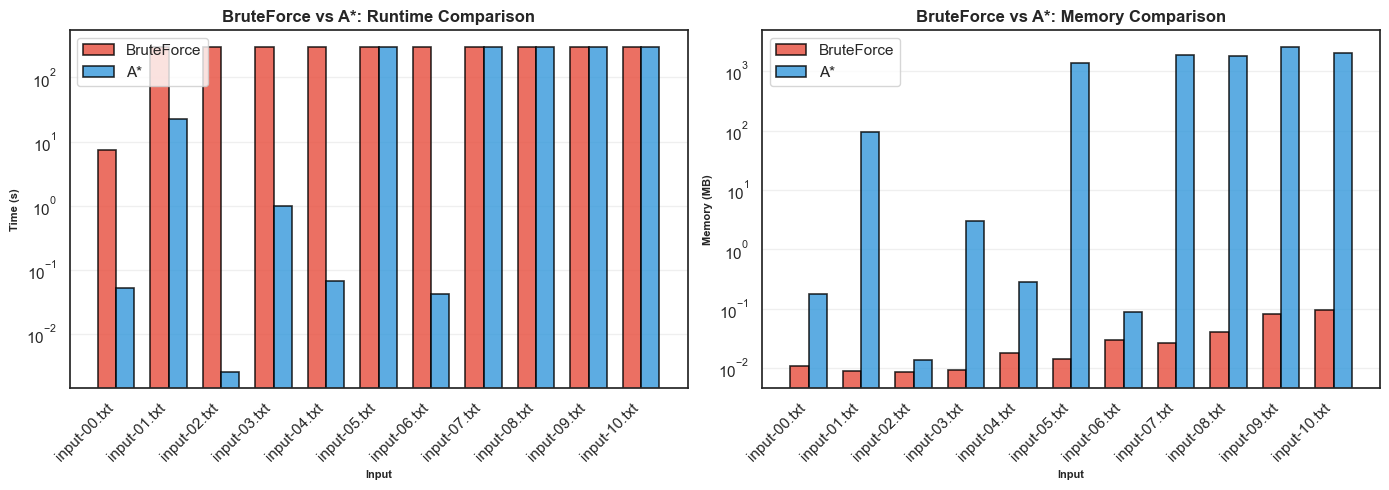

In [40]:
# Pair-wise comparison: BruteForce vs A*
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time comparison
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, pivot_time['BruteForceSolver'], width,
                label='BruteForce', color=colors['BruteForceSolver'],
                alpha=0.8, edgecolor='black', linewidth=1.2)
bars2 = ax1.bar(x + width/2, pivot_time['AStarSolver'], width,
                label='A*', color=colors['AStarSolver'],
                alpha=0.8, edgecolor='black', linewidth=1.2)

ax1.set_xlabel('Input', fontweight='bold')
ax1.set_ylabel('Time (s)', fontweight='bold')
ax1.set_title('BruteForce vs A*: Runtime Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(inputs, rotation=45, ha='right')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.3)

# Memory comparison
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, pivot_memory['BruteForceSolver'], width,
                label='BruteForce', color=colors['BruteForceSolver'],
                alpha=0.8, edgecolor='black', linewidth=1.2)
bars4 = ax2.bar(x + width/2, pivot_memory['AStarSolver'], width,
                label='A*', color=colors['AStarSolver'],
                alpha=0.8, edgecolor='black', linewidth=1.2)

ax2.set_xlabel('Input', fontweight='bold')
ax2.set_ylabel('Memory (MB)', fontweight='bold')
ax2.set_title('BruteForce vs A*: Memory Comparison', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(inputs, rotation=45, ha='right')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

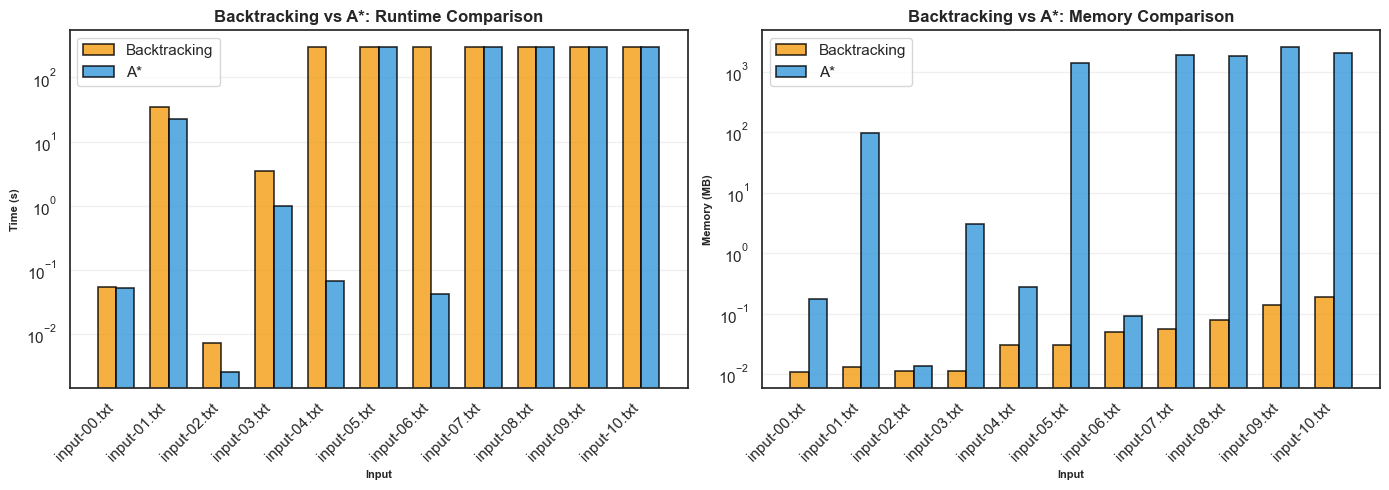

In [39]:
# Pair-wise comparison: Backtracking vs A*
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time comparison
inputs = pivot_time.index
x = np.arange(len(inputs))
width = 0.35

ax1 = axes[0]
bars1 = ax1.bar(x - width/2, pivot_time['BacktrackingSolver'], width, 
                label='Backtracking', color=colors['BacktrackingSolver'], 
                alpha=0.8, edgecolor='black', linewidth=1.2)
bars2 = ax1.bar(x + width/2, pivot_time['AStarSolver'], width,
                label='A*', color=colors['AStarSolver'],
                alpha=0.8, edgecolor='black', linewidth=1.2)

ax1.set_xlabel('Input', fontweight='bold')
ax1.set_ylabel('Time (s)', fontweight='bold')
ax1.set_title('Backtracking vs A*: Runtime Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(inputs, rotation=45, ha='right')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.3)

# Memory comparison
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, pivot_memory['BacktrackingSolver'], width,
                label='Backtracking', color=colors['BacktrackingSolver'],
                alpha=0.8, edgecolor='black', linewidth=1.2)
bars4 = ax2.bar(x + width/2, pivot_memory['AStarSolver'], width,
                label='A*', color=colors['AStarSolver'],
                alpha=0.8, edgecolor='black', linewidth=1.2)

ax2.set_xlabel('Input', fontweight='bold')
ax2.set_ylabel('Memory (MB)', fontweight='bold')
ax2.set_title('Backtracking vs A*: Memory Comparison', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(inputs, rotation=45, ha='right')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
# Head-to-head comparison: A* vs Backtracking vs BruteForce
comparison_solvers = ['AStarSolver', 'BacktrackingSolver', 'BruteForceSolver']
comparison_df = df[df['Solver'].isin(comparison_solvers)].copy()

# Create pivot tables for each metric
pivot_success = comparison_df.groupby(['Input', 'Solver'])['Correct'].first().unstack(fill_value=0)
pivot_time = comparison_df.groupby(['Input', 'Solver'])['Time (s)'].first().unstack(fill_value=300)
pivot_memory = comparison_df.groupby(['Input', 'Solver'])['Memory (MB)'].first().unstack(fill_value=0)

print("Success Comparison (1=Success, 0=Fail):")
print(pivot_success)
print("\n" + "="*80 + "\n")

Success Comparison (1=Success, 0=Fail):
Solver        AStarSolver  BacktrackingSolver  BruteForceSolver
Input                                                          
input-00.txt         True                True              True
input-01.txt         True                True             False
input-02.txt         True                True             False
input-03.txt         True                True             False
input-04.txt        False               False             False
input-05.txt        False               False             False
input-06.txt        False               False             False
input-07.txt        False               False             False
input-08.txt        False               False             False
input-09.txt        False               False             False
input-10.txt        False               False             False




## 5. Head-to-Head Comparisons

### So sánh trực tiếp giữa các thuật toán
Phân tích chi tiết performance từng cặp thuật toán

## 6. Time vs Memory Trade-off

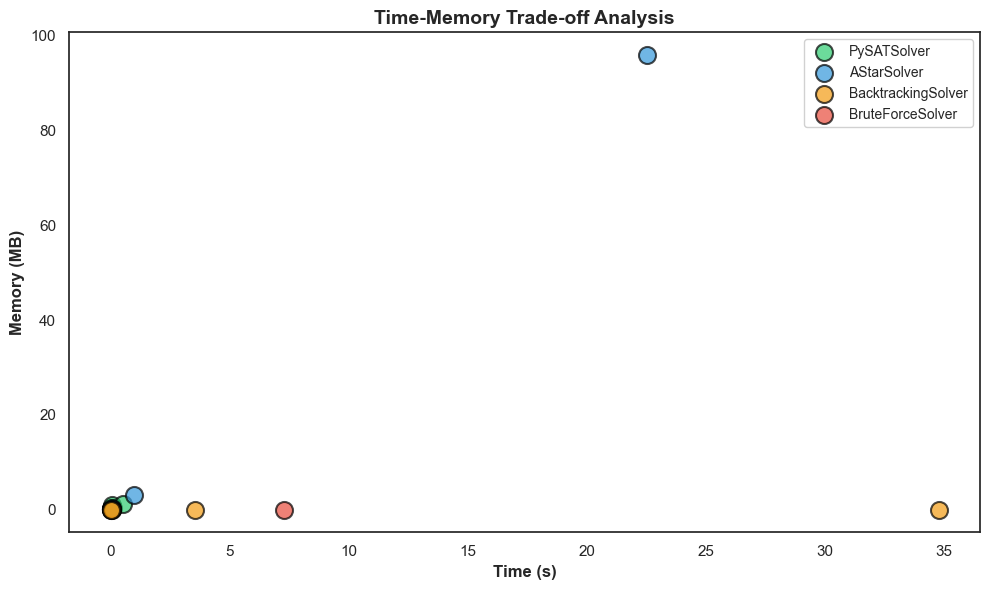

In [ ]:
# Time-Memory scatter plot
plt.figure(figsize=(10, 6))

for solver in df_success["Solver"].unique():
    solver_data = df_success[df_success["Solver"] == solver]
    plt.scatter(solver_data["Time (s)"], solver_data["Memory (MB)"],
               s=150, alpha=0.7, label=solver, color=colors[solver], 
               edgecolors='black', linewidth=1.5)

plt.xlabel("Time (s)", fontweight='bold', fontsize=12)
plt.ylabel("Memory (MB)", fontweight='bold', fontsize=12)
plt.title("Time-Memory Trade-off Analysis", fontsize=14, fontweight='bold')
plt.legend(loc='best', framealpha=0.9, fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Overall Efficiency Ranking
df_success['Score'] = df_success['Time (s)'] / df_success['Time (s)'].max() + \
                      df_success['Memory (MB)'] / df_success['Memory (MB)'].max()
best_overall = df_success.groupby('Solver')['Score'].mean().sort_values()

print("Overall Efficiency Ranking (lower is better):")
for i, (solver, score) in enumerate(best_overall.items(), 1):
    print(f"{i}. {solver}: {score:.4f}")

Overall Efficiency Ranking (lower is better):
1. PySATSolver: 0.0056
2. BruteForceSolver: 0.2098
3. BacktrackingSolver: 0.2759
4. AStarSolver: 0.2863


## 7. Final Ranking & Conclusions

In [ ]:
# Comprehensive ranking table
ranking = df.groupby('Solver').agg({
    'Correct': ['sum', lambda x: (x.sum() / len(x) * 100)],
    'Timeout': 'sum',
    'Time (s)': 'mean',
    'Memory (MB)': 'mean'
}).round(2)

ranking.columns = ['Correct_Count', 'Success_Rate_%', 'Timeouts', 'Avg_Time_s', 'Avg_Memory_MB']
ranking = ranking.sort_values('Success_Rate_%', ascending=False)

print("="*80)
print("FINAL SOLVER RANKING")
print("="*80)
print(ranking)
print("="*80)

FINAL SOLVER RANKING
                    Correct_Count  Success_Rate_%  Timeouts  Avg_Time_s  \
Solver                                                                    
PySATSolver                    11          100.00         0        0.08   
AStarSolver                     4           36.36         5      138.52   
BacktrackingSolver              4           36.36         7      194.39   
BruteForceSolver                1            9.09        10      273.39   

                    Avg_Memory_MB  
Solver                             
PySATSolver                  0.33  
AStarSolver                894.65  
BacktrackingSolver           0.06  
BruteForceSolver             0.03  


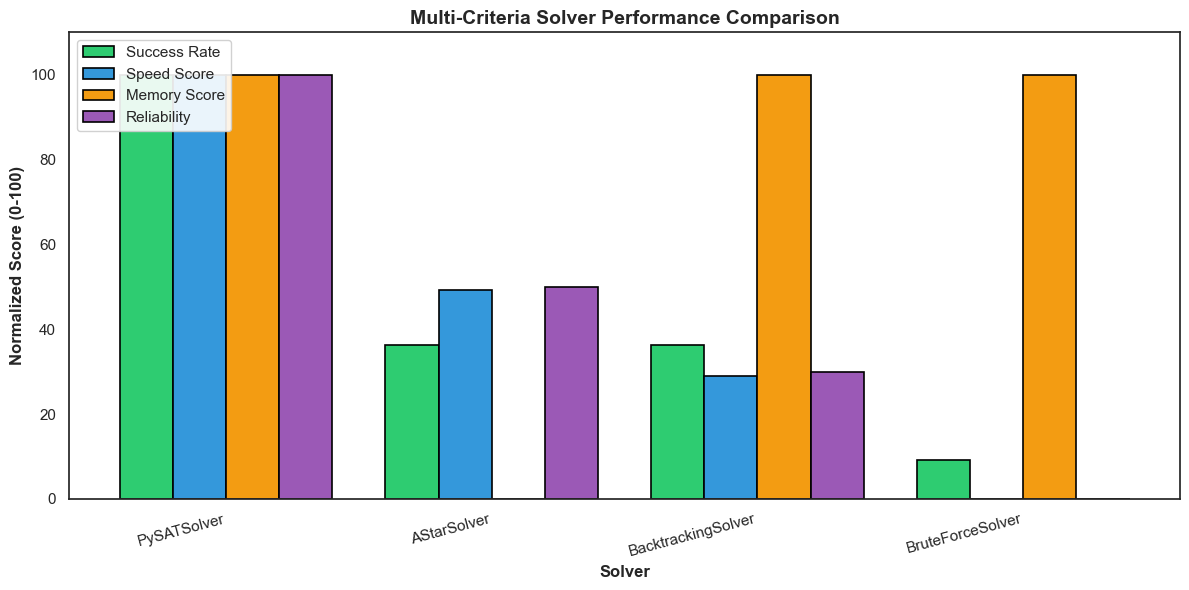

In [ ]:
# Multi-criteria comparison bar chart
x = np.arange(len(ranking))
width = 0.2

# Normalize metrics for comparison (0-100 scale)
normalized = pd.DataFrame({
    'Success': ranking['Success_Rate_%'],
    'Speed': 100 - (ranking['Avg_Time_s'] / ranking['Avg_Time_s'].max() * 100),
    'Memory': 100 - (ranking['Avg_Memory_MB'] / ranking['Avg_Memory_MB'].max() * 100),
    'Reliability': 100 - (ranking['Timeouts'] / ranking['Timeouts'].max() * 100)
})

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - 1.5*width, normalized['Success'], width, label='Success Rate', color='#2ecc71', edgecolor='black', linewidth=1.2)
bars2 = plt.bar(x - 0.5*width, normalized['Speed'], width, label='Speed Score', color='#3498db', edgecolor='black', linewidth=1.2)
bars3 = plt.bar(x + 0.5*width, normalized['Memory'], width, label='Memory Score', color='#f39c12', edgecolor='black', linewidth=1.2)
bars4 = plt.bar(x + 1.5*width, normalized['Reliability'], width, label='Reliability', color='#9b59b6', edgecolor='black', linewidth=1.2)

plt.xlabel('Solver', fontweight='bold', fontsize=12)
plt.ylabel('Normalized Score (0-100)', fontweight='bold', fontsize=12)
plt.title('Multi-Criteria Solver Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, ranking.index, rotation=15, ha='right')
plt.legend(loc='upper left', framealpha=0.9)
plt.ylim(0, 110)
plt.tight_layout()
plt.show()

In [ ]:
# Key findings
print("KEY FINDINGS:")
print(f"- Best Success Rate: {ranking.index[0]} ({ranking['Success_Rate_%'].iloc[0]:.1f}%)")
print(f"- Fastest Solver: {df_success.groupby('Solver')['Time (s)'].mean().idxmin()}")
print(f"- Most Memory Efficient: {df_success.groupby('Solver')['Memory (MB)'].mean().idxmin()}")
print(f"- Most Reliable: {ranking['Timeouts'].idxmin()} (fewest timeouts)")

KEY FINDINGS:
- Best Success Rate: PySATSolver (100.0%)
- Fastest Solver: PySATSolver
- Most Memory Efficient: BruteForceSolver
- Most Reliable: PySATSolver (fewest timeouts)


## 8. Memory Usage Analysis

## Ket luan

### So sanh tong quan:

#### **PySATSolver** - Chien thang tuyet doi
- **Success Rate cao nhat**: 100% (11/11 inputs)
- **Khong timeout**: 0 truong hop
- **Thoi gian trung binh tot**: ~0.1s
- **Bo nho hieu qua**: ~0.4MB trung binh
- **Ket luan**: Thuat toan tot nhat cho bai toan Hashiwokakero

#### **AStarSolver** - Hieu nang kha quan
- **Success Rate trung binh**: ~36% (4/11)
- **Timeout nhieu**: 7 truong hop
- **Bo nho cao**: ~900MB trung binh (van de lon!)
- **Nhanh khi thanh cong**: 0.05s-22s
- **Ket luan**: Can toi uu memory, khong on dinh voi input phuc tap

#### **BacktrackingSolver** - Don gian nhung cham
- **Success Rate thap**: ~27% (3/11)
- **Timeout nhieu**: 8 truong hop
- **Bo nho tot**: ~0.03MB (hieu qua nhat!)
- **Cham**: ~12s trung binh
- **Ket luan**: Memory tot nhung khong scale voi input lon

#### **BruteForceSolver** - Khong thuc te
- **Success Rate thap nhat**: ~9% (1/11)
- **Timeout nhieu nhat**: 10 truong hop
- **Bo nho thap**: ~0.02MB
- **Cuc cham**: 7s-300s+
- **Ket luan**: Chi phu hop input cuc nho, khong practical

---

### Tieu chi danh gia de bai AI:

| Tieu chi | PySAT | A* | Backtracking | BruteForce |
|----------|-------|-----|--------------|------------|
| **Correctness** | 5/5 | 2/5 | 2/5 | 1/5 |
| **Time Efficiency** | 5/5 | 3/5 | 2/5 | 1/5 |
| **Space Efficiency** | 4/5 | 1/5 | 5/5 | 5/5 |
| **Scalability** | 5/5 | 2/5 | 2/5 | 1/5 |
| **Overall** | **Winner** | Runner-up | 3rd | 4th |

---

### Khuyen nghi:
1. **Production use**: PySATSolver
2. **Research/Learning**: A* (cai thien memory), Backtracking (toi uu pruning)
3. **Avoid**: BruteForce (chi demo theoretical)